Necessary imports

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 20.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.

In [ ]:
import torch
import numpy as np
import pandas as pd
import transformers
import evaluate
from tqdm import tqdm

from huggingface_hub import notebook_login
from datasets import load_dataset, Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import DataCollatorWithPadding, pipeline
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

Load data and make preprocessing

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("neelshah18/arxivdataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arxivdataset


In [ ]:
data = pd.read_json(path + "/arxivData.json")

In [ ]:
data

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017
...,...,...,...,...,...,...,...,...,...
40995,"[{'name': 'Vitaly Feldman'}, {'name': 'Pravesh...",18,1404.4702v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,We study the complexity of learning and approx...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Nearly Tight Bounds on $\ell_1$ Approximation ...,2014
40996,"[{'name': 'Orly Avner'}, {'name': 'Shie Mannor'}]",22,1404.5421v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,We consider the problem of multiple users targ...,"[{'term': 'cs.LG', 'scheme': 'http://arxiv.org...",Concurrent bandits and cognitive radio networks,2014
40997,"[{'name': 'Ran Zhao'}, {'name': 'Deanna Needel...",22,1404.5899v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",4,"In this paper, we compare and analyze clusteri...","[{'term': 'math.NA', 'scheme': 'http://arxiv.o...",A Comparison of Clustering and Missing Data Me...,2014
40998,"[{'name': 'Zongyan Huang'}, {'name': 'Matthew ...",25,1404.6369v1,"[{'rel': 'related', 'href': 'http://dx.doi.org...",4,Cylindrical algebraic decomposition(CAD) is a ...,"[{'term': 'cs.SC', 'scheme': 'http://arxiv.org...",Applying machine learning to the problem of ch...,2014


In [ ]:
data.shape

(41000, 9)

In [ ]:
data.isnull().sum()

,0
author,0
day,0
id,0
link,0
month,0
summary,0
tag,0
title,0
year,0


In [ ]:
data['tag'][0]
# Понять что там с таргетами и их форматом
# Вероятно labels_column = data['terms'].apply(literal_eval)
# labels = labels_column.explode().inique()

"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}, {'term': 'cs.CL', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}, {'term': 'cs.CV', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}, {'term': 'cs.NE', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}, {'term': 'stat.ML', 'scheme': 'http://arxiv.org/schemas/atom', 'label': None}]"

In [ ]:
data['category'] = [eval(i)[0]['term'].strip() for i in data['tag']]  # remain single label only (easy way)
data['category']

,category
0,cs.AI
1,cs.CL
2,cs.CL
3,stat.ML
4,cs.CL
...,...
40995,cs.LG
40996,cs.LG
40997,math.NA
40998,cs.SC


Here we also need to collect all unique values for arxiv areas and save them to appropriate mapping "category -- index"

In [ ]:
unique_categories = np.unique(data['category'])
num_categories = len(unique_categories)
category_to_ind = {}
for i, cat in enumerate(unique_categories):
    category_to_ind[cat] = i
num_categories

126

In [ ]:
data = pd.DataFrame({
    "category": unique_categories,
    "category_index": np.arange(num_categories),
}).set_index("category").join(data.set_index("category"), how="right", sort=False).reset_index()

In [ ]:
data['category_id'] = [category_to_ind[cat] for cat in data['category']]
data['category_id']

,category_id
0,15
1,20
2,20
3,124
4,20
...,...
40995,37
40996,37
40997,80
40998,50


To train model we will concatenate title and abstract

In [ ]:
data['text_feature'] = data['title'] + "\n" + data['summary']

In [ ]:
data['text_feature'].to_list()

['Dual Recurrent Attention Units for Visual Question Answering\nWe propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.',
 'Sequential Short-Text Classification with Recurrent and Convolutional\n  Neural Networks\nRecent approaches based on artificial neural networks (ANNs) have shown

(array([9.1700e+02, 7.7200e+03, 1.5965e+04, 1.1266e+04, 4.1430e+03,
        9.6100e+02, 1.9000e+01, 4.0000e+00, 2.0000e+00, 3.0000e+00]),
 array([  66. ,  430.4,  794.8, 1159.2, 1523.6, 1888. , 2252.4, 2616.8,
        2981.2, 3345.6, 3710. ]),
 <BarContainer object of 10 artists>)

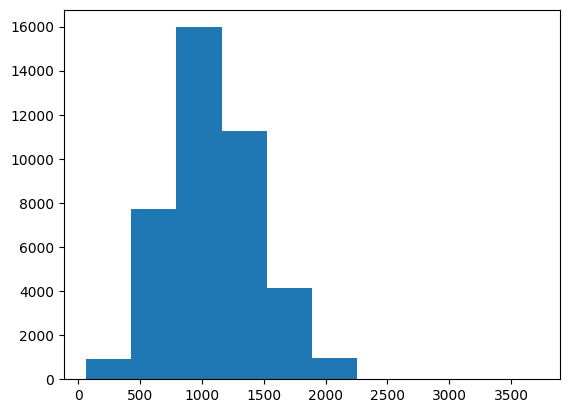

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(feature) for feature in data['text_feature'].to_list()])

In [ ]:
max_seq_len = 1000

In [ ]:
data.head()

,category,category_index,author,day,id,link,month,summary,tag,title,year,category_id,text_feature
0,cs.AI,15,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018,15,Dual Recurrent Attention Units for Visual Ques...
1,cs.CL,20,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016,20,Sequential Short-Text Classification with Recu...
2,cs.CL,20,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016,20,Multiresolution Recurrent Neural Networks: An ...
3,stat.ML,124,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017,124,Learning what to share between loosely related...
4,cs.CL,20,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017,20,A Deep Reinforcement Learning Chatbot\nWe pres...


Train test split

In [ ]:
len(data)

41000

In [ ]:
data = data.loc[:, ['text_feature', 'category']]


In [ ]:
data

,text_feature,category
0,Dual Recurrent Attention Units for Visual Ques...,cs.AI
1,Sequential Short-Text Classification with Recu...,cs.CL
2,Multiresolution Recurrent Neural Networks: An ...,cs.CL
3,Learning what to share between loosely related...,stat.ML
4,A Deep Reinforcement Learning Chatbot\nWe pres...,cs.CL
...,...,...
40995,Nearly Tight Bounds on $\ell_1$ Approximation ...,cs.LG
40996,Concurrent bandits and cognitive radio network...,cs.LG
40997,A Comparison of Clustering and Missing Data Me...,math.NA
40998,Applying machine learning to the problem of ch...,cs.SC


In [ ]:
indices = list(range(len(data)))
np.random.shuffle(indices)

train_indices, val_indices = indices[:32000], indices[32000:]

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_pandas(data.iloc[train_indices], split='train')
val_ds = Dataset.from_pandas(data.iloc[val_indices], split='test')

In [ ]:
batch_size = 64
num_workers = 2

HF model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
checkpoint_model = "dimsafin/arxiv_distilbert_model"
tokenizer = AutoTokenizer.from_pretrained(checkpoint_model)
def preprocess_function(examples):
    return tokenizer(examples["text_feature"], max_length=512, truncation=True, padding='max_length')

In [ ]:
train_ds = train_ds.map(preprocess_function, batched=True)
val_ds = val_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [ ]:
labels_map = ClassLabel(num_classes=num_categories, names=list(unique_categories))

def transform_labels(row):
    # default name for a label (label or label_ids)
    return {"label": labels_map.str2int(row["category"])}

train_ds = train_ds.map(transform_labels, batched=True)
val_ds = val_ds.map(transform_labels, batched=True)

train_ds = train_ds.cast_column('label', labels_map)
val_ds = val_ds.cast_column('label', labels_map)

Map:   0%|          | 0/32000 [00:00<?, ? examples/s]

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/32000 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9000 [00:00<?, ? examples/s]

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
#    "distilbert/distilbert-base-uncased",
    checkpoint_model,
    num_labels=num_categories,
    id2label={i:cat for i, cat in enumerate(unique_categories)},
    label2id=category_to_ind).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
training_args = TrainingArguments(
    output_dir="arxiv_distilbert_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id="arxiv_distilbert_model",
    hub_token=token
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()  # it's not the last model version but anyway

Epoch,Training Loss,Validation Loss,Accuracy
1,1.469300,1.361324,0.631778
2,1.177800,1.215741,0.658556
3,1.000800,1.190308,0.658000
4,0.869300,1.202424,0.660222
5,0.703900,1.257401,0.655222


KeyboardInterrupt: 

In [ ]:
tokenizer.save_pretrained("arxiv_distilbert_model")

In [ ]:
trainer.save_model("arxiv_distilbert_model")

In [ ]:
trainer.push_to_hub()